# Robot Performance Measurement and Failure Analysis

### By Ben Toaz

## Data Collection and Preparation

In [36]:
import pandas as pd 

# CobotOps - https://archive.ics.uci.edu/dataset/963/ur3+cobotops
df_cobots = pd.read_excel("data/cobot_dataset.xlsx")

# For later: RAD - https://github.com/ubc-systopia/dsn-2022-rad-artifact/tree/main

In [37]:
df_cobots.head()


,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost
0,1,2022-10-26T08:17:21.847Z,0.109628,27.875,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,...,2.955651e-01,-0.000490,0.001310,-0.132836,-0.007479,-0.152962,0.082732,1,0.0,False
1,2,2022-10-26T08:17:22.852Z,0.595605,27.875,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,...,-7.391485e-30,-0.000304,0.002185,0.001668,-0.000767,0.000417,0.505895,1,0.0,False
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.875,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,...,1.369386e-01,0.007795,-2.535874,0.379867,0.000455,-0.496856,0.079420,1,0.0,False
3,4,2022-10-26T08:17:24.863Z,0.065053,27.875,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,...,-9.030032e-02,-0.004911,-0.009096,-0.384196,0.018411,0.425559,0.083325,1,0.0,False
4,5,2022-10-26T08:17:25.877Z,0.884140,27.875,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,...,1.268088e-01,0.005567,0.001138,-0.353284,0.014994,0.180989,0.086379,1,0.0,False


In [38]:
df_cobots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7409 entries, 0 to 7408
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Num                   7409 non-null   int64  
 1   Timestamp             7409 non-null   object 
 2   Current_J0            7363 non-null   float64
 3   Temperature_T0        7355 non-null   float64
 4   Current_J1            7355 non-null   float64
 5   Temperature_J1        7355 non-null   float64
 6   Current_J2            7355 non-null   float64
 7   Temperature_J2        7355 non-null   float64
 8   Current_J3            7355 non-null   float64
 9   Temperature_J3        7355 non-null   float64
 10  Current_J4            7355 non-null   float64
 11  Temperature_J4        7355 non-null   float64
 12  Current_J5            7355 non-null   float64
 13  Temperature_J5        7355 non-null   float64
 14  Speed_J0              7355 non-null   float64
 15  Speed_J1             

In [39]:
# redundant
df_cobots.drop(columns=['Num'], inplace=True)

# miss named
df_cobots.rename(columns={'Temperature_T0': 'Temperature_J0'}, inplace=True)

# extra space
df_cobots.rename(columns={'cycle ': 'cycle'}, inplace=True)

# Encoding timestamps

# Convert to datetime
df_cobots['Timestamp'] = df_cobots['Timestamp'].astype(str).str.strip('"').str.strip("'").str.strip()
df_cobots['Timestamp'] = pd.to_datetime(df_cobots['Timestamp'], format='mixed', utc=True)

# Extract components, only use hour or shorter since all done in a single day

# df_cobots['year'] = df_cobots['Timestamp'].dt.year
# df_cobots['month'] = df_cobots['Timestamp'].dt.month
# df_cobots['day'] = df_cobots['Timestamp'].dt.day
# df_cobots['dayofweek'] = df_cobots['Timestamp'].dt.dayofweek
df_cobots['hour'] = df_cobots['Timestamp'].dt.hour
df_cobots['minute'] = df_cobots['Timestamp'].dt.minute
df_cobots['second'] = df_cobots['Timestamp'].dt.second

df_cobots.drop(columns=['Timestamp'], inplace=True)

In [40]:
df_cobots

,Current_J0,Temperature_J0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,Temperature_J4,...,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost,hour,minute,second
0,0.109628,27.8750,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,-0.062540,32.2500,...,-0.132836,-0.007479,-0.152962,0.082732,1,0.0,False,8,17,21
1,0.595605,27.8750,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,-1.062762,32.2500,...,0.001668,-0.000767,0.000417,0.505895,1,0.0,False,8,17,22
2,-0.229474,27.8750,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,-0.668869,32.3125,...,0.379867,0.000455,-0.496856,0.079420,1,0.0,False,8,17,23
3,0.065053,27.8750,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,-0.819755,32.2500,...,-0.384196,0.018411,0.425559,0.083325,1,0.0,False,8,17,24
4,0.884140,27.8750,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,-0.966427,32.3125,...,-0.353284,0.014994,0.180989,0.086379,1,0.0,False,8,17,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,-0.109017,37.1875,-2.261695,40.3125,-1.082678,40.6875,-0.494714,43.3750,-0.019447,45.2500,...,0.000000,0.000000,0.000000,0.080013,264,0.0,False,15,36,2
7405,-0.098536,37.1875,-2.251992,40.3125,-1.094420,40.6875,-0.515789,43.3750,-0.009186,45.2500,...,0.000000,0.000000,0.000000,0.078740,264,0.0,False,15,36,3
7406,-0.121100,37.1875,-2.280791,40.2500,-1.121319,40.6875,-0.502406,43.3750,-0.002978,45.2500,...,0.000000,0.000000,0.000000,0.091471,264,0.0,False,15,36,4
7407,-0.129370,37.1875,-2.269061,40.3125,-1.091610,40.6250,-0.491158,43.3750,-0.001136,45.2500,...,0.000000,0.000000,0.000000,0.090026,264,0.0,False,15,36,5


<Axes: >

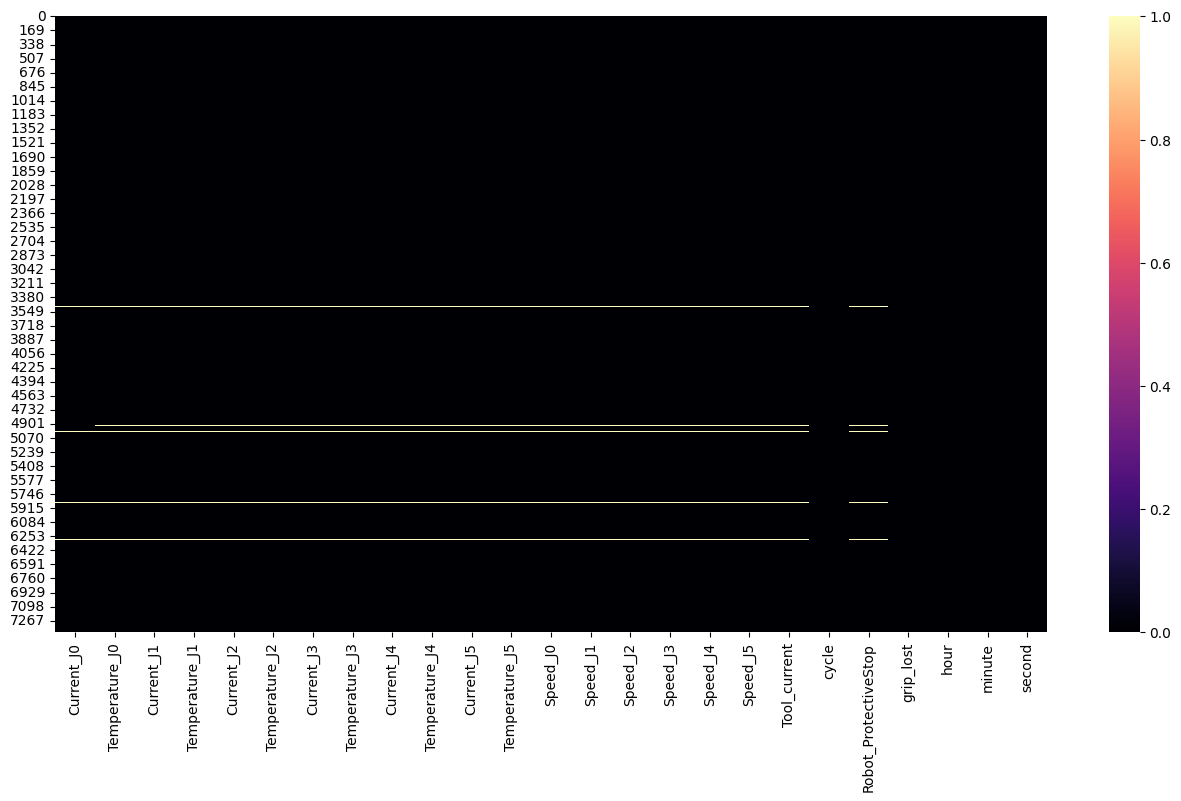

In [41]:
# Missingness

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,8))
sns.heatmap(df_cobots.isna(), cmap="magma")

Missingness occurs infrequently, and when it does, it happens across most of the features. This suggests that it is MCAR, which doesn't require too advanced techniques to fix.

In [42]:
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# https://plotly.com/python/time-series/
#  Claude Sonnet 4.5, 10-11-25

df_cobots['time'] = (
    df_cobots['hour'] * 3600 + df_cobots['minute'] * 60 + df_cobots['second']
)
df_cobots = df_cobots.sort_values('time')

# Define your column groups
feature_type_lst = ["Current", "Speed", "Temperature"]
unit = ["A", "m/s", "Degrees C"]
colors = px.colors.qualitative.Dark24

for feature_type, unit in zip(feature_type_lst, unit):
    cols1 = [f"{feature_type}_J{i}" for i in range(0, 3)]
    cols2 = [f"{feature_type}_J{i}" for i in range(3, 6)]

    # Create subplots
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        subplot_titles=(f'{feature_type} Joints 0-2', f'{feature_type} Joints 3-5'),
                        vertical_spacing=0.1)

    # Add current traces to first subplot
    for i, col in enumerate(cols1):
        fig.add_trace(go.Scatter(x=df_cobots['time'], y=df_cobots[col],
                                name=col, mode='lines', line=dict(color=colors[i])), row=1, col=1)

    # Add speed traces to second subplot
    for i, col in enumerate(cols2):
        fig.add_trace(go.Scatter(x=df_cobots['time'], y=df_cobots[col], 
                                name=col, mode='lines', line=dict(color=colors[i+3])), row=2, col=1)

    # Add rangeslider to bottom subplot only
    fig.update_xaxes(rangeslider_visible=True, row=2, col=1)

    fig.update_xaxes(title_text="Time (s)", row=2, col=1, rangeslider_visible=True)
    fig.update_yaxes(title_text=f"{feature_type} ({unit})", row=1, col=1)
    fig.update_yaxes(title_text=f"{feature_type} ({unit})", row=2, col=1)

    # Update layout
    fig.update_layout(height=800, title='Speed Time Series')
    fig.show()


Looking at the time series data confirms this. Small gaps occur between readings, indicating it is an occasional sensor error. We can fix this easily with a nearest neighbor method or simply interpolating between the proceeding and following readings in time. Measurements are very stable so this won't affect the overall statistics by much.

In [43]:
cols_interpolate = [col for col in df_cobots.columns if col != 'Robot_ProtectiveStop']
df_cobots[cols_interpolate] = df_cobots[cols_interpolate].interpolate(method='linear')


In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import pearsonr

df_missing = df_cobots.copy()

# 2. Add an indicator column for missingness in 'sepal width'
df_missing['Stop_Missing'] = df_missing['Robot_ProtectiveStop'].isna().astype(int)

for col in df_missing.columns:
    # 3. Check for correlation between 'sepal width missing' and 'petal length'
    correlation, p_value = pearsonr(df_missing['Stop_Missing'], df_missing[col])

    print(f"Correlation between 'Stop_Missing' and {col}: {correlation:.3f}")
    print(f"P-value: {p_value:.3f}")

    # Visualize the relationship
    if p_value < 0.025:
        # plt.figure(figsize=(8, 6))
        # sns.boxplot(x='Stop_Missing', y=col, data=df_missing)
        # plt.title(f"Relationship between Missingness in 'Stop_Missing' and '{col}'")
        # plt.show()

        pass

Correlation between 'Stop_Missing' and Current_J0: 0.014
P-value: 0.224
Correlation between 'Stop_Missing' and Temperature_J0: 0.040
P-value: 0.001
Correlation between 'Stop_Missing' and Current_J1: 0.004
P-value: 0.713
Correlation between 'Stop_Missing' and Temperature_J1: 0.039
P-value: 0.001
Correlation between 'Stop_Missing' and Current_J2: -0.005
P-value: 0.651
Correlation between 'Stop_Missing' and Temperature_J2: 0.038
P-value: 0.001
Correlation between 'Stop_Missing' and Current_J3: 0.002
P-value: 0.862
Correlation between 'Stop_Missing' and Temperature_J3: 0.037
P-value: 0.002
Correlation between 'Stop_Missing' and Current_J4: 0.002
P-value: 0.892
Correlation between 'Stop_Missing' and Temperature_J4: 0.036
P-value: 0.002
Correlation between 'Stop_Missing' and Current_J5: -0.008
P-value: 0.514
Correlation between 'Stop_Missing' and Temperature_J5: 0.035
P-value: 0.003
Correlation between 'Stop_Missing' and Speed_J0: 0.008
P-value: 0.518
Correlation between 'Stop_Missing' and S

There is no significant relationship between any of the features and the missing E-stop flags for the robot. This means I can reasonably impute using the most common value for the boolean, which is simply 0.

In [51]:
df_cobots.fillna({'Robot_ProtectiveStop': 0}, inplace=True)
df_cobots['grip_lost'] = df_cobots['grip_lost'].astype(int)

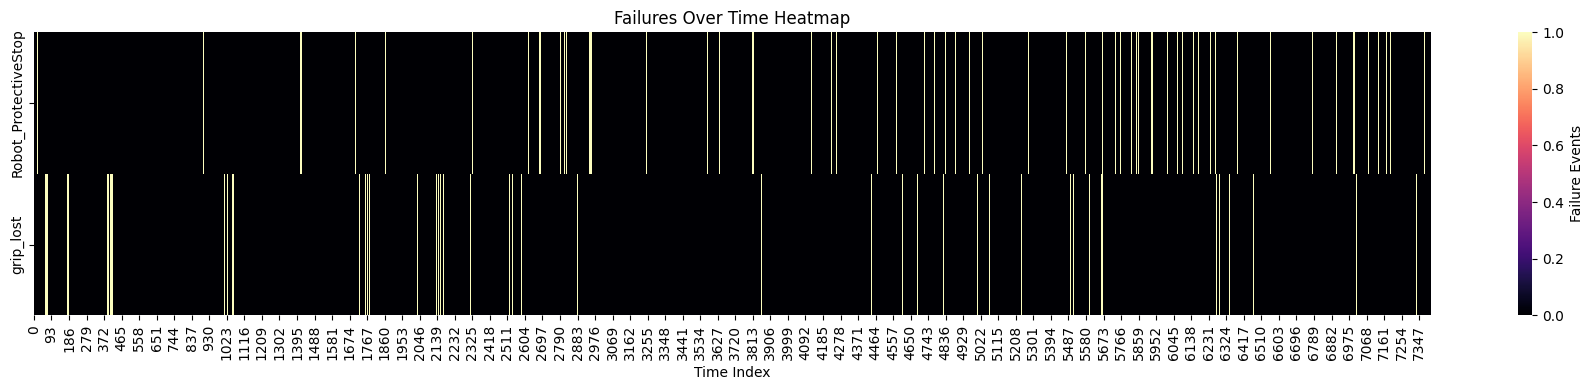

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transpose so time is on y-axis and features on x-axis
df_failures = df_cobots[['Robot_ProtectiveStop', 'grip_lost']].T

plt.figure(figsize=(18, 4))
sns.heatmap(df_failures, cmap='magma', cbar_kws={"label": "Failure Events"})
plt.xlabel('Time Index')
plt.title('Failures Over Time Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

feature_type_lst = ["Current", "Speed", "Temperature"]
unit = ["A", "m/s", "Degrees C"]
colors = px.colors.qualitative.Dark24

fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[f'{feature} Distribution' for feature in feature_type_lst],
    horizontal_spacing=0.1
)

# Loop through each feature type
for feat_idx, (feature_type, unit_label) in enumerate(zip(feature_type_lst, unit)):
    row = feat_idx + 1  
    
    # Add histogram for each joint (J0-J5)
    for joint_idx in range(6):
        col_name = f"{feature_type}_J{joint_idx}"
        
        fig.add_trace(
            go.Histogram(
                x=df_cobots[col_name],
                name=f'Joint {joint_idx}',
                marker=dict(color=colors[joint_idx]),
                opacity=0.7,
                legendgroup=f'joint{joint_idx}',  # Group by joint for legend
                showlegend=(feat_idx == 0)  # Only show legend once (on first subplot)
            ),
            row=row, col=1
        )
    
    fig.update_xaxes(title_text=f"{feature_type} ({unit_label})", row=row, col=1)

fig.update_yaxes(title_text="Count", row=1, col=1)

# Update layout
fig.update_layout(
    height=1000,
    title_text="Joint Feature Distributions",
    barmode='overlay',  
    showlegend=True,
    legend=dict(
        title="Joints",
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    )
)

fig.show()

In [48]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Scaled using Cloud Sonnet 4.5, 10-11-25

# Create 2x3 subplots
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f'Joint {i}' for i in range(6)],
    vertical_spacing=0.225,
    horizontal_spacing=0.125
)

# Loop through joints 0-5
for joint_idx in range(6):
    # Select columns for this joint
    cols = []
    for feature_type in feature_type_lst:
        cols.append(f"{feature_type}_J{joint_idx}")
    
    cols += ['Robot_ProtectiveStop', 'grip_lost', 'cycle', 'Tool_current']
    
    # Calculate correlation
    df_corr = df_cobots[cols].corr().round(2)
    
    # Mask upper triangle
    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Apply mask and drop empty rows/cols
    df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(axis='columns', how='all')

    # Create text array with blanks instead of nan
    text_values = df_corr_viz.values.astype(str)
    text_values[text_values == 'nan'] = ''
    
    # Calculate position in grid
    row = (joint_idx // 3) + 1  # 1 or 2
    col = (joint_idx % 3) + 1   # 1, 2, or 3
    
    # Add heatmap to subplot
    fig.add_trace(
        go.Heatmap(
            z=df_corr_viz.values,
            x=df_corr_viz.columns,
            y=df_corr_viz.index,
            colorscale='Viridis',
            zmid=0,
            text=text_values,
            texttemplate='%{text}',
            textfont={"size": 8},
            showscale=(joint_idx == 5)  # Only show colorbar on last plot
        ),
        row=row, col=col
    )
    
    # Update axes for this subplot
    fig.update_xaxes(tickangle=-45, row=row, col=col)

fig.update_layout(
    height=800,
    title_text="Correlation Analysis by Joint",
    showlegend=False
)

fig.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from itertools import combinations

feature_pairs = list(combinations(feature_type_lst, 2))

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[f'{pair[0]} vs {pair[1]}' for pair in feature_pairs],
    horizontal_spacing=0.125
)

for pair_idx, (feat1, feat2) in enumerate(feature_pairs):
    cols = []
    for joint_idx in range(6):
        cols.append(f"{feat1}_J{joint_idx}")
    for joint_idx in range(6):
        cols.append(f"{feat2}_J{joint_idx}")
    
    df_corr = df_cobots[cols].corr().round(2)
    
    # Mask upper triangle
    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Apply mask and drop empty rows/cols
    df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(axis='columns', how='all')

    # Create text array with blanks instead of nan
    text_values = df_corr_viz.values.astype(str)
    text_values[text_values == 'nan'] = ''
    
    col = pair_idx + 1  # 1, 2, or 3
    
    fig.add_trace(
        go.Heatmap(
            z=df_corr_viz.values,
            x=df_corr_viz.columns,
            y=df_corr_viz.index,
            colorscale='Viridis',
            zmid=0,
            text=text_values,
            texttemplate='%{text}',
            textfont={"size": 8},
            showscale=(pair_idx == 2)
        ),
        row=1, col=col
    )
    
    fig.update_xaxes(tickangle=-45, row=1, col=col)

fig.update_layout(
    height=550,
    title_text="Cross-Feature Correlation Analysis",
    showlegend=False
)

fig.show()

### Advanced Data Techniques

### Advanced Data Processing

## Exploratory Data Analysis and Visualization 


### Sophisticated Analysis and Visualization

## Data Processing

## Streamlit App

### Enhanced App Features

## GitHub